In [54]:
# Twitter libs

import tweepy
from tweepy import OAuthHandler

# Text processing

from preprocessor import api as p
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *

# Visualisation

import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

# Other libs

import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import csv
import re
import string
import warnings

# Options

matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

In [9]:
consumerKey = "of8pFw3XadVNRodnEFFzpTeYD"
consumerSecret = "QGitE2TztoJZ9vS0K5dQJ74wP82PLh0peyHvKpNmNu7GLYNPnR"
accessToken = "290461392-0QWg7NYG7XiEjJznJFuWczE4RUuqlqx8KAX1s6MK"
accessTokenSecret = "VjtSOALJ7NII0ZVEcHGDwl8dEDtMBFtI6WqeEgOHXFdpr"

auth = OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [10]:
#file location
coronaVirus_tweets = "coronaVirus.csv"

In [11]:
#columns of the csv file
COLS = ['id', 'created_at', 'source', 'original_text','clean_text', 'sentiment','polarity','subjectivity', 'lang',
        'favorite_count', 'retweet_count', 'original_author', 'possibly_sensitive', 'hashtags',
        'user_mentions', 'place', 'place_coord_boundaries']

In [12]:
#set two date variables for date range
start_date = '2020-03-22'
end_date = '2020-03-29'

In [13]:
# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

#Emoji patterns
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)

In [14]:
#mrhod clean_tweets()
def clean_tweets(tweet):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(tweet)

    #after tweepy preprocessing the colon left remain after removing mentions
    #or RT sign in the beginning of the tweet
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    
    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)

    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []

    #looping through conditions
    for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)

In [15]:
#method write_tweets()
def write_tweets(keyword, file):
    # If the file exists, then read the existing data from the CSV file.
    if os.path.exists(file):
        df = pd.read_csv(file, header=0)
    else:
        df = pd.DataFrame(columns=COLS)
        
    #page attribute in tweepy.cursor and iteration
#    for page in tweepy.Cursor(api.search, q=keyword,
#                              count=200, include_rts=False, since=start_date).pages(50):

    for page in tweepy.Cursor(api.search, q=keyword,
                              count=200, include_rts=False, since=start_date).pages(1000):
        for status in page:
            new_entry = []
            status = status._json

            ## check whether the tweet is in english or skip to the next tweet
            if status['lang'] != 'en':
                continue

            #when run the code, below code replaces the retweet amount and
            #no of favorires that are changed since last download.
            if status['created_at'] in df['created_at'].values:
                i = df.loc[df['created_at'] == status['created_at']].index[0]
                if status['favorite_count'] != df.at[i, 'favorite_count'] or \
                   status['retweet_count'] != df.at[i, 'retweet_count']:
                    df.at[i, 'favorite_count'] = status['favorite_count']
                    df.at[i, 'retweet_count'] = status['retweet_count']
                continue


           #tweepy preprocessing called for basic preprocessing
            clean_text = p.clean(status['text'])

            #call clean_tweet method for extra preprocessing
            filtered_tweet=clean_tweets(clean_text)

            #pass textBlob method for sentiment calculations
            blob = TextBlob(filtered_tweet)
            Sentiment = blob.sentiment

            #seperate polarity and subjectivity in to two variables
            polarity = Sentiment.polarity
            subjectivity = Sentiment.subjectivity

            #new entry append
            new_entry += [status['id'], status['created_at'],
                          status['source'], status['text'],filtered_tweet, Sentiment,polarity,subjectivity, status['lang'],
                          status['favorite_count'], status['retweet_count']]

            #to append original author of the tweet
            new_entry.append(status['user']['screen_name'])

            try:
                is_sensitive = status['possibly_sensitive']
            except KeyError:
                is_sensitive = None
            new_entry.append(is_sensitive)

            # hashtagas and mentiones are saved using comma separted
            hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
            new_entry.append(hashtags)
            mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
            new_entry.append(mentions)

            #get location of the tweet if possible
            try:
                location = status['user']['location']
            except TypeError:
                location = ''
            new_entry.append(location)

            try:
                coordinates = [coord for loc in status['place']['bounding_box']['coordinates'] for coord in loc]
            except TypeError:
                coordinates = None
            new_entry.append(coordinates)

            single_tweet_df = pd.DataFrame([new_entry], columns=COLS)
            df = df.append(single_tweet_df, ignore_index=True)
            csvFile = open(file, 'a' ,encoding='utf-8')
    df.to_csv(csvFile, mode='a', columns=COLS, index=False, encoding="utf-8")

In [16]:
#declare keywords as a query for three categories
coronaVirus_keywords = '#coronavirus OR #corona OR #virus OR #covid-19 OR #COVID-19 OR #chinesevirus OR #wuhanvirus'

In [17]:
#call main method passing keywords and file path
#write_tweets(coronaVirus_keywords, coronaVirus_tweets)

In [18]:
df = pd.read_csv("coronaVirus.csv", error_bad_lines=False)

# Columns of the csv file

- 'id' 
- 'created_at'
- 'source'
- 'original_text'
- 'clean_text'
- 'sentiment'
- 'polarity'
- 'subjectivity' 
- 'lang'
- 'favorite_count' 
- 'retweet_count'
- 'original_author' 
- 'possibly_sensitive' 
- 'hashtags'
- 'user_mentions'
- 'place'
- 'place_coord_boundaries'

In [19]:
# Wordcloud masks

coronaVirus1_mask = np.array(Image.open("coronaVirus1_mask.png"))
coronaVirus2_mask = np.array(Image.open("coronaVirus2_mask.png"))
coronaVirus3_mask = np.array(Image.open("coronaVirus3_mask.png"))

# Fix

coronaVirus1_mask = coronaVirus1_mask.reshape((coronaVirus1_mask.shape[0],-1), order='F')
coronaVirus2_mask = coronaVirus2_mask.reshape((coronaVirus2_mask.shape[0],-1), order='F')
coronaVirus3_mask = coronaVirus3_mask.reshape((coronaVirus3_mask.shape[0],-1), order='F')

In [20]:
# Helper function to create wordclouds masks - masking functions requires all 
# white part of the mask should be 255 not 0 (integer type). 

def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

In [21]:
# Transformed wordcloud masks

transformed_coronaVirus1_mask = np.ndarray((coronaVirus1_mask.shape[0],coronaVirus1_mask.shape[1]), np.int32)
transformed_coronaVirus2_mask = np.ndarray((coronaVirus2_mask.shape[0],coronaVirus2_mask.shape[1]), np.int32)
transformed_coronaVirus3_mask = np.ndarray((coronaVirus3_mask.shape[0],coronaVirus3_mask.shape[1]), np.int32)

for i in range(len(coronaVirus1_mask)):
    transformed_coronaVirus1_mask[i] = list(map(transform_format, coronaVirus1_mask[i]))  
for i in range(len(coronaVirus2_mask)):
    transformed_coronaVirus2_mask[i] = list(map(transform_format, coronaVirus2_mask[i]))
for i in range(len(coronaVirus3_mask)):
    transformed_coronaVirus3_mask[i] = list(map(transform_format, coronaVirus3_mask[i]))

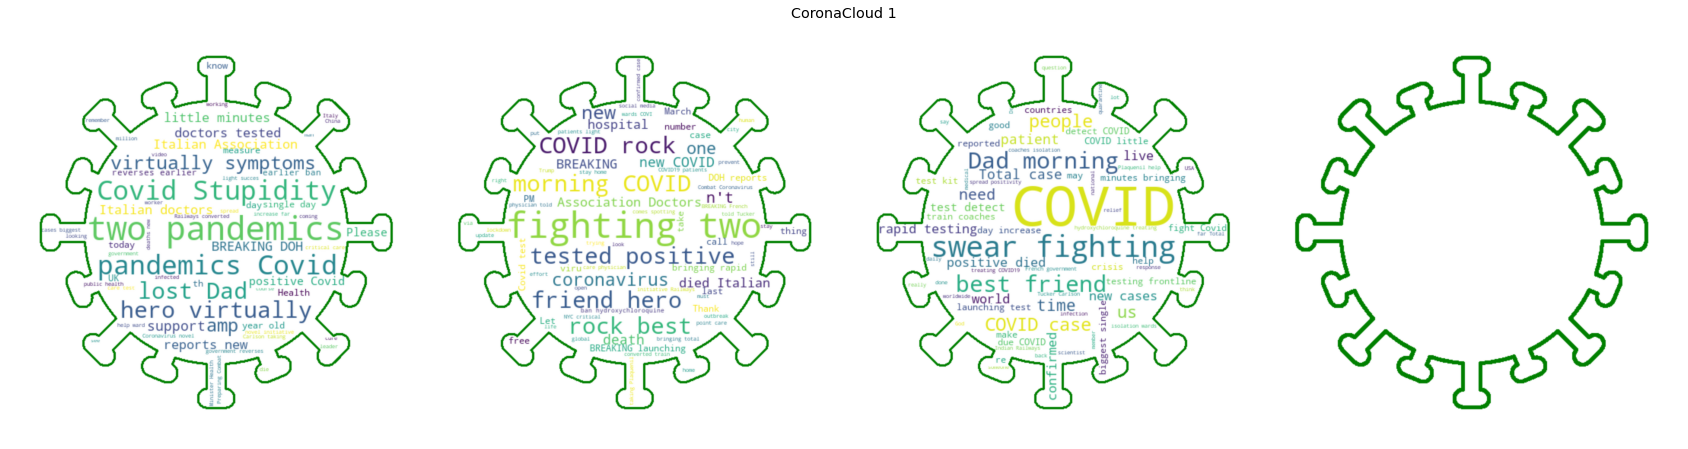

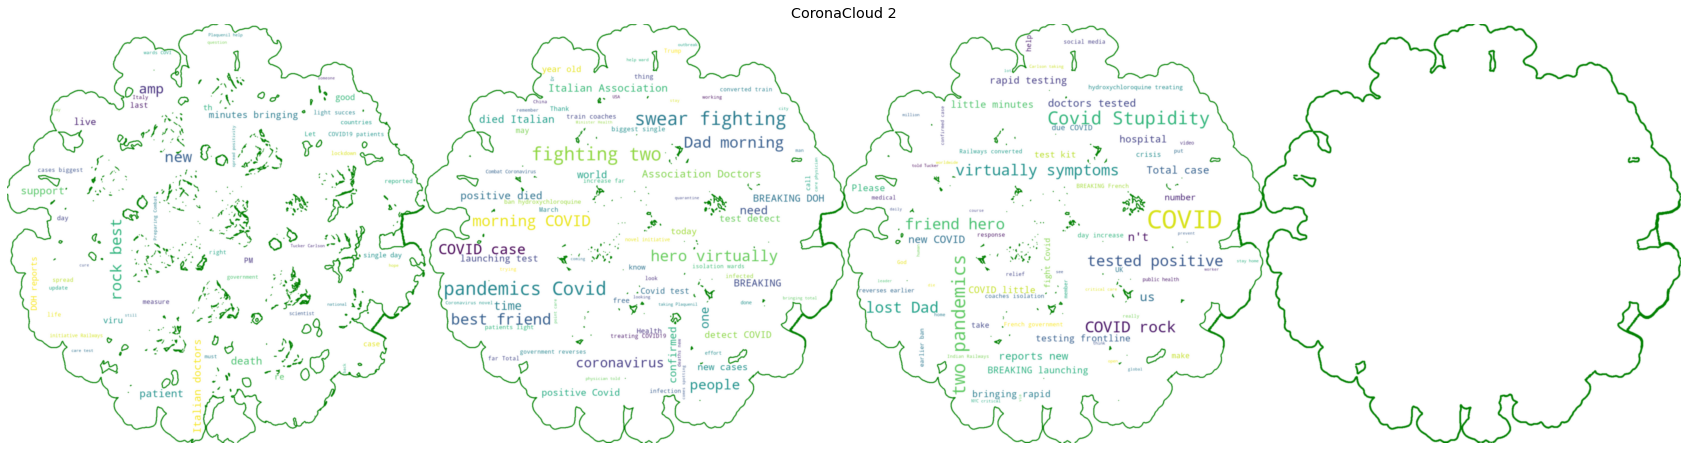

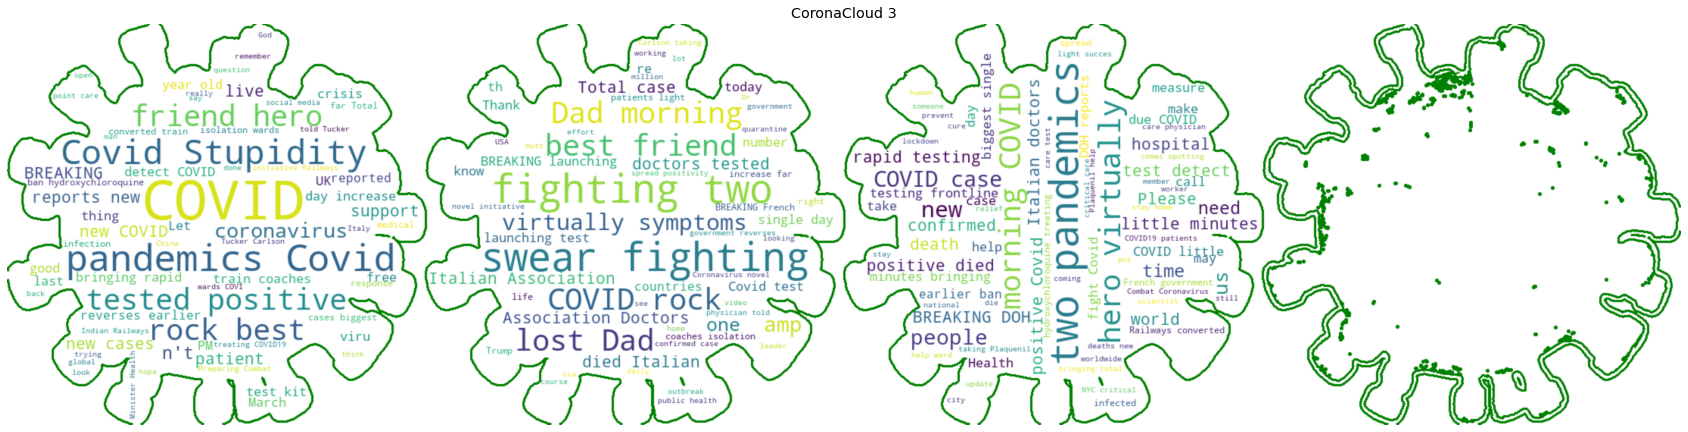

In [22]:
def wordcloud(df, col, img_mask, img_title):
    
    df[col] = df[col].astype(str)
    
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(max_font_size=72, 
                          max_words=200, 
                          background_color="white",
                          stopwords=stopwords,
                          random_state = 2019, 
                          width=1920, 
                          height=1080,
                          mask=img_mask,
                          contour_width=3, 
                          contour_color='green').generate(" ".join([i for i in df[col]]))
    
    plt.figure( figsize=(30,10) )
    plt.imshow(wordcloud, interpolation='gaussian')
    plt.axis("off")
    plt.title(img_title)
    wordcloud.to_file(f"{img_title}.png")

wordcloud(df,"clean_text", transformed_coronaVirus1_mask, "CoronaCloud 1")
wordcloud(df,"clean_text", transformed_coronaVirus2_mask, "CoronaCloud 2")
wordcloud(df,"clean_text", transformed_coronaVirus3_mask, "CoronaCloud 3")

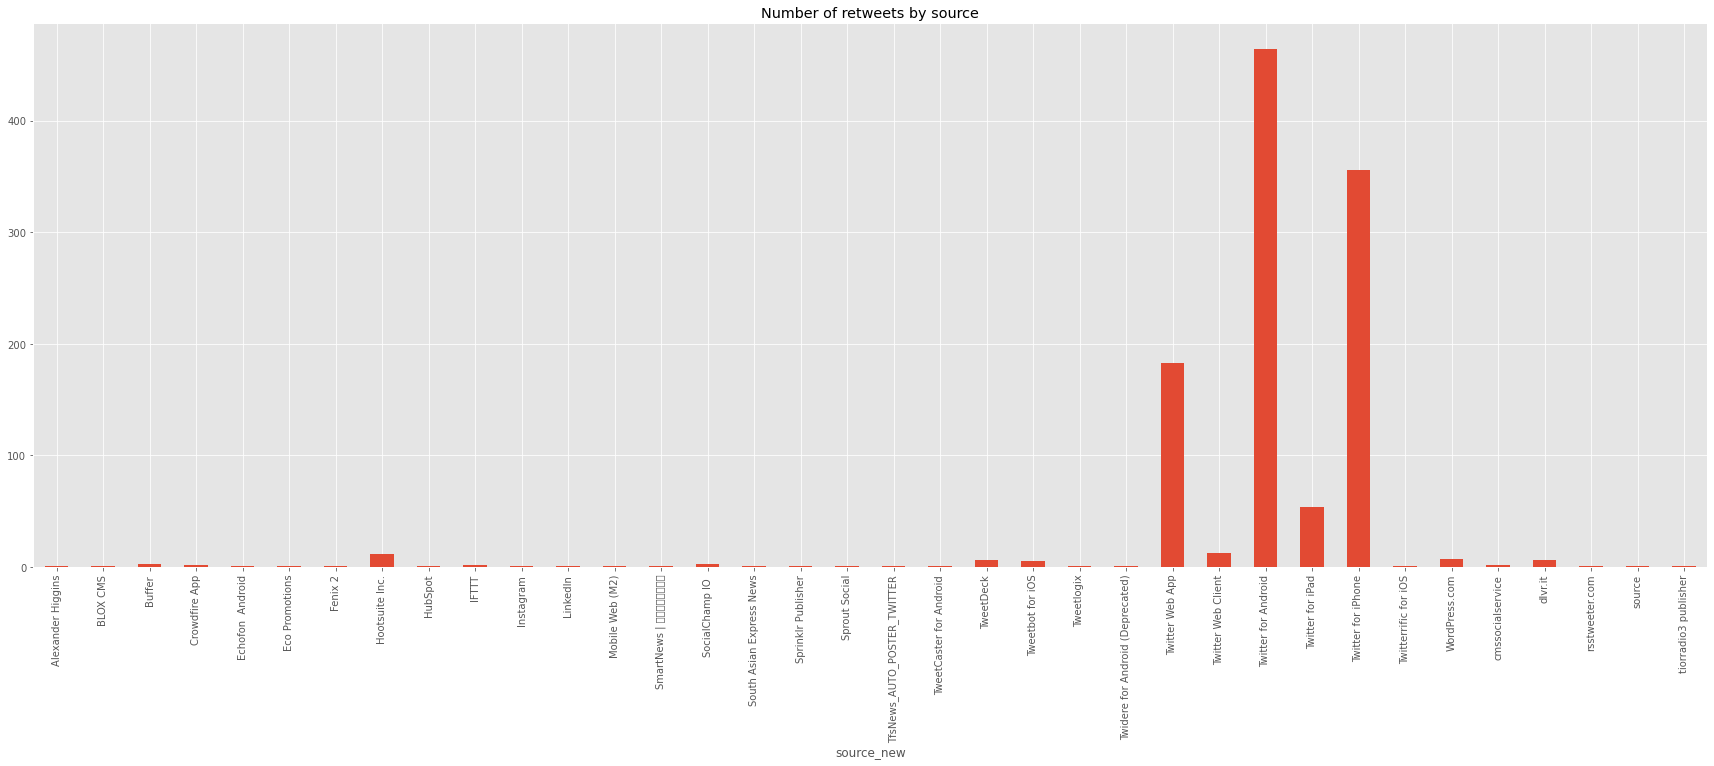

In [36]:
def plotRetweetsBySource(df):

    df['source_new'] = ''

    for i in range(len(df['source'])):
        m = re.search('>(.*)<',df['source'][i])
        try:
            df['source_new'][i]=m.group(0)
        except AttributeError:
            df['source_new'][i]=df['source'][i]

    df['source_new'] = df['source_new'].str.replace('>', '', case=False)
    df['source_new'] = df['source_new'].str.replace('<', '', case=False)
    df['source_new'] = df['source_new'].astype(str)

    df.groupby('source_new')['retweet_count'].nunique().plot(kind='bar', figsize=(30, 10))
    plt.title('Number of retweets by source')
    
    plt.savefig('RetweetsBySource.png')
    plt.show()

plotRetweetsBySource(df)


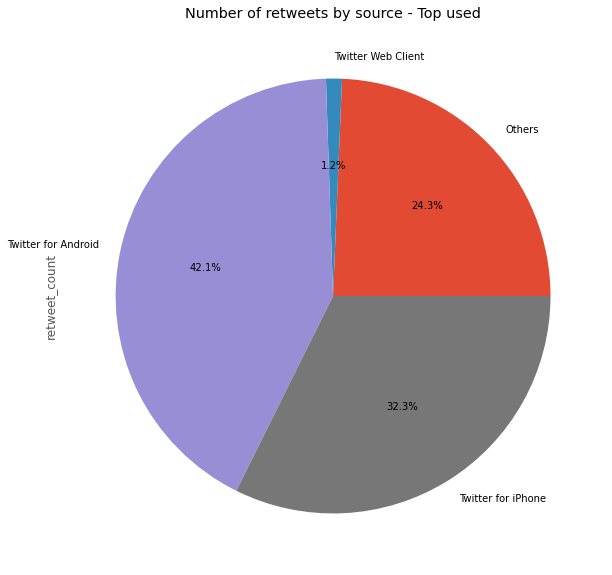

In [52]:
def plotRetweetsBySourceTop(df):
    
    df['source_new2'] = ''

    for i in range(len(df['source_new'])):
        if df['source_new'][i] not in ['Twitter for Android','Twitter Web Client','Twitter for iPhone']:
            df['source_new2'][i] = 'Others'
        else:
            df['source_new2'][i] = df['source_new'][i]    
    
    df.groupby('source_new2')['retweet_count'].nunique().plot(kind='pie', figsize=(30, 10), autopct='%1.1f%%', )
    plt.title('Number of retweets by source - Top used')
    
    plt.savefig('RetweetsBySourceTop.png')
    plt.show()
    
plotRetweetsBySourceTop(df)

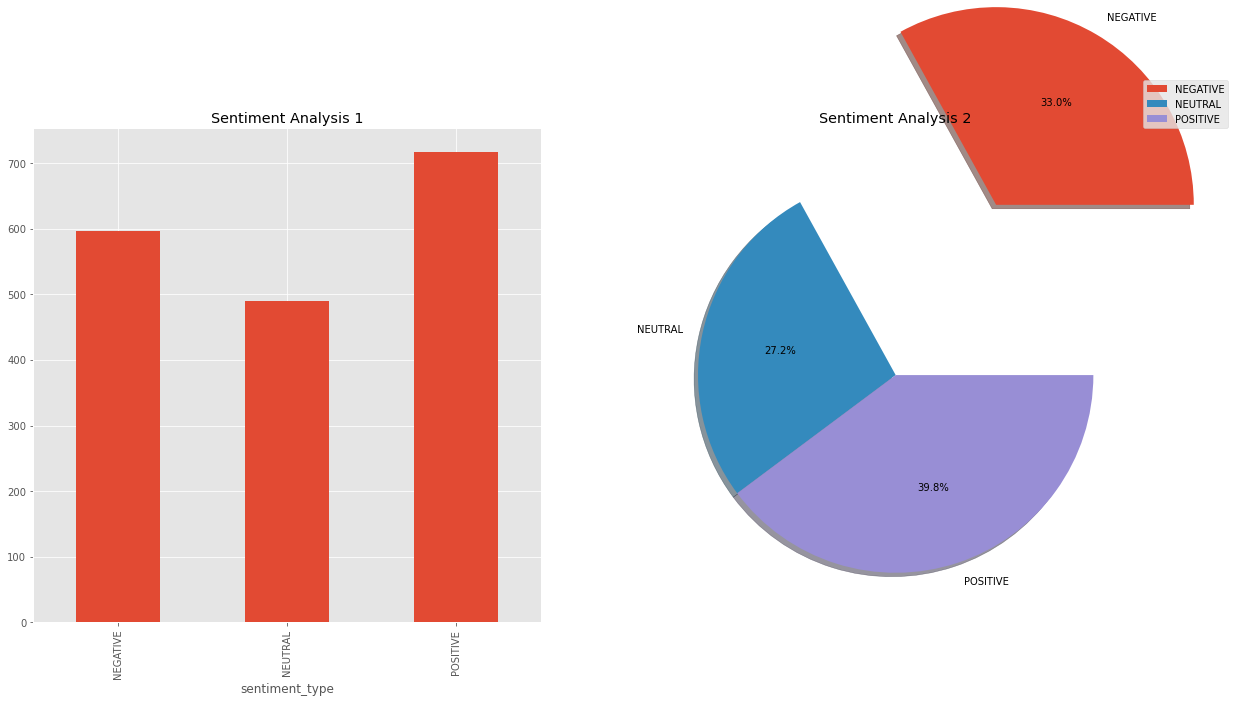

In [50]:
def sentimentAnalysis(df):
    
    df['text_lem'] = [''.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in df['clean_text']]       
    vectorizer = TfidfVectorizer(max_df=0.5,max_features=10000,min_df=10,stop_words='english',use_idf=True)
    X = vectorizer.fit_transform(df['text_lem'].str.upper())
    sid = SentimentIntensityAnalyzer()

    df['sentiment_compound_polarity']=df.text_lem.apply(lambda x:sid.polarity_scores(x)['compound'])
    df['sentiment_neutral']=df.text_lem.apply(lambda x:sid.polarity_scores(x)['neu'])
    df['sentiment_negative']=df.text_lem.apply(lambda x:sid.polarity_scores(x)['neg'])
    df['sentiment_pos']=df.text_lem.apply(lambda x:sid.polarity_scores(x)['pos'])
    df['sentiment_type']=''

    df.loc[df.sentiment_compound_polarity>0,'sentiment_type']='POSITIVE'
    df.loc[df.sentiment_compound_polarity==0,'sentiment_type']='NEUTRAL'
    df.loc[df.sentiment_compound_polarity<0,'sentiment_type']='NEGATIVE'

    df_sentiment = df.groupby(['sentiment_type'])['sentiment_neutral'].count()
    df_sentiment.rename("",inplace=True)

    plt.subplot(221)
    df_sentiment.transpose().plot(kind='bar',figsize=(20, 20))
    plt.title('Sentiment Analysis 1')

    plt.subplot(222)
    explode = (1, 0, 0)
    df_sentiment.plot(kind='pie',figsize=(20, 20),autopct='%1.1f%%',shadow=True,explode=explode)
    plt.legend(bbox_to_anchor=(1, 1), loc=3, borderaxespad=0.)
    plt.title('Sentiment Analysis 2')
    
    plt.savefig('sentimentAnalysis.png')
    plt.show()

sentimentAnalysis(df)